## No PCA Loss Landscapes

An approach for computing and visualizing 3D loss landscapes for high-dimensional models. This no-PCA loss landscape approach involves holding all the parameters of the model constant (except for two), and visualizing the loss over the two non-constant parameters.

In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

### Classifiers

#### Logistic Regression

In [2]:
class LogisticRegression():
    
    def loss(self, X, y, theta):
        YX = X * y[:,None]
        hy = YX @ theta
        loss = np.log(1+np.exp(-hy)).mean()
        error = (hy <= 0).mean()
        return loss, error
    
    def gradient(self, X, y, theta):
        YX = X * y[:,None]
        m = X.shape[0]
        gradient = -YX.T @ (1/(1+np.exp(YX @ theta)))/m
        return gradient

    def gradient_descent(self, X, y, alpha, iters):
        m,n = X.shape
        theta = np.zeros((iters+1, n))
        loss, err = np.zeros(iters), np.zeros(iters)
        for t in range(iters):
            loss[t], err[t] = self.loss(X, y, theta[t])
            theta[t+1] -= alpha * self.gradient(X, y, theta[t])
        theta = theta[0:iters, :]
        return theta, loss, err

#### SVM

In [3]:
class SVM():
  
    def loss(self, X, y, theta):
        YX = X * y[:,None]
        hy = YX @ theta
        loss = np.maximum(1-hy,0).mean()
        error = (hy <= 0).mean()
        return loss, error
    
    def gradient(self, X, y, theta):
        YX = X * y[:,None]
        m = X.shape[0]
        gradient = -YX.T @ (YX @ theta <= 1)/m
        return gradient

    def gradient_descent(self, X, y, alpha, iters):
        m,n = X.shape
        theta = np.zeros((iters+1, n))
        loss, err = np.zeros(iters), np.zeros(iters)
        for t in range(iters):
            loss[t], err[t] = self.loss(X, y, theta[t])
            theta[t+1] -= alpha * self.gradient(X, y, theta[t])
        theta = theta[0:iters, :]
        return theta, loss, err

#### Neural Network

[ Not completed yet ]

In [4]:
def nn(x, W, b, f):
    """
    Compute output of a neural network.

    Input:
        x: numpy array of input
        W: list of numpy arrays for W parameters
        b: list of numpy arraos for b parameters
        f: list of activation functions for each layer

    Output:
        z: list of activationsn, where each element in the list is a tuple:
           (z_i, z'_i)
           for z_i and z'_i each being a numpy array of activations/derivatives
    """

    z = [(x,)] + [[]]*len(W)
    for i in range(len(W)):
        z[i+1] = (f[i](W[i] @ z[i][0] + b[i])[0],
                  f[i](W[i] @ z[i][0] + b[i])[1])
    return z


In [ ]:
def nn_loss(x, y, W, b, f):
    """
    Compute loss of a neural net prediction, plus gradients of parameters

    Input:
        x: numpy array of input
        y: numpy array of output
        W: list of numpy arrays for W parameters
        b: list of numpy arrays for b parameters
        f: list of activation functions for each layer

    Output tuple: (L, dW, db)
        L: softmax loss on this example
        dW: list of numpy arrays for gradients of W parameters
        db: list of numpy arrays for gradients of b parameters
    """

    z = nn(x,W,b,f)
    L, dL = softmax_loss(z[-1][0], y)
    
    db = [np.zeros(bi.shape) for bi in b]
    dW = [np.zeros(Wi.shape) for Wi in W]
    
    g = dL
    db[-1] = g * z[-1][1]
    dW[-1] = (g * z[-1][1])[:,None] @ z[-2][0][None,:]
    
    for i in range(len(db)-2, -1, -1):
        g = W[i+1].T @ (g * z[i+2][1])
        db[i] = g * z[i+1][1]
        dW[i] = (g * z[i+1][1])[:,None] @ z[i][0][None,:]

    return L, dW, db


In [ ]:
def nn_sgd(X,y, Xt, yt, W, b, f, epochs=10, alpha = 0.01):
    """
    Run stochastic gradient descent to solve linear softmax regression.

    Inputs:
        X: numpy array of training inputs
        y: numpy array of training outputs
        Xt: numpy array of testing inputs
        yt: numpy array of testing outputs
        W: list of W parameters (with initial values)
        b: list of b parameters (with initial values)
        f: list of activation functions
        epochs: number of passes to make over the whole training set
        alpha: step size

    Output: None (you can directly update the W and b inputs in place)
    """
    m = X.shape[0]
    print("{0:10}|{1:10}|{2:10}|{3:10}".\
          format("Test Err", "Train Err", "Test Loss", "Train Loss"))

    # TODO: Modify W and b in-place.
    for i in range(epochs):
        yp = np.vstack([nn(x, W, b, f)[-1][0] for x in X_train])
        ypt = np.vstack([nn(x, W, b, f)[-1][0] for x in X_test])
        print_errors(yp, y, ypt, yt)
        for i in range(m):
            x_i = X_train[i]
            y_i = y_train[i]
            L, dW, db = nn_loss(x_i, y_i, W, b, f)
            for j in range(len(W)):
                b[j] -= alpha * db[j]
                W[j] -= alpha * dW[j]


In [ ]:
np.random.seed(0)
layer_sizes = [784, 200, 100, 10]
W = [0.1*np.random.randn(n,m) for m,n in zip(layer_sizes[:-1], layer_sizes[1:])]
b = [0.1*np.random.randn(n) for n in layer_sizes[1:]]
f = [f_relu]*(len(layer_sizes)-2) + [f_lin]

z = nn(X_train[0], W, b, f)

L, dW, db = nn_loss(X_train[0], y_train[0], W, b, f)

# # nn_sgd should update W and b in-place.
nn_sgd(X_train, y_train, X_test, y_test, W, b, f, epochs=10, alpha=0.01)

### Dataset: Iris

In [5]:
df = pd.read_table('data/iris.data.txt', sep=',', 
                   names=['sepal length', 'sepal width', 'petal length', 'petal width', 'label'])
df = df[df['label'].isin(['Iris-setosa', 'Iris-versicolor'])]   # only keep 2 classes
df = df.reset_index(drop=True)
# Normalize features: zero mean, unit variance
df.iloc[:,0:4] = (df.iloc[:,0:4] - df.iloc[:,0:4].mean(axis=0))/df.iloc[:,0:4].std(axis=0)
print('Dimensions:', df.shape)
df.head()

Dimensions: (100, 5)


,sepal length,sepal width,petal length,petal width,label
0,-0.578153,0.852839,-1.009275,-1.033044,Iris-setosa
1,-0.889826,-0.197455,-1.009275,-1.033044,Iris-setosa
2,-1.201499,0.222662,-1.078309,-1.033044,Iris-setosa
3,-1.357336,0.012604,-0.940241,-1.033044,Iris-setosa
4,-0.733990,1.062898,-1.009275,-1.033044,Iris-setosa


#### Train a logistic regression model

In [6]:
X = df.iloc[:,0:4].as_matrix()
y = ((df['label'] == 'Iris-setosa') * 2 - 1).as_matrix()   # convert to 1 / -1 labels
lr_model = LogisticRegression()
theta, loss, err = lr_model.gradient_descent(X, y, 0.1, 100)

In [7]:
print(theta.shape)
theta = theta[-1]   # chose best theta
theta

(100, 4)


array([-0.0334807 ,  0.03180329, -0.0449288 , -0.04448841])

#### Visualize loss landscape for logistic regression model

Visualize loss surface by holding all but one parameter constant at their optimal values. Sweep out values of the non-constant parameter around it's optimal value. Evaluate the loss for each combination of parameter values.

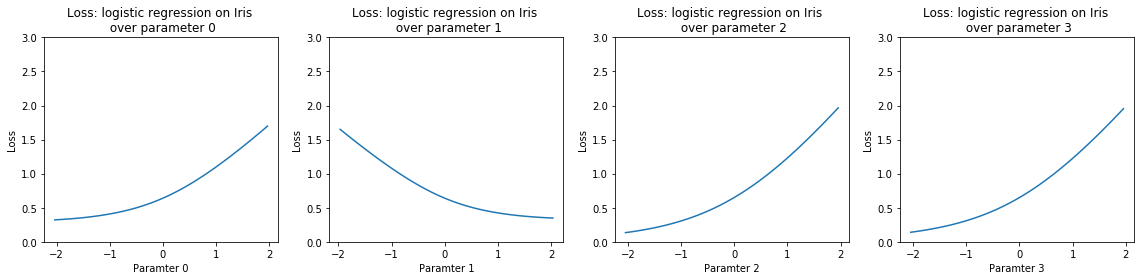

In [8]:
offset = 2   # constant used to sweep out parameter values
plt.figure(figsize=(16, 4))
for i in range(len(theta)):
    theta_to_change = theta[i]   # the parameter value not held constant
    theta_to_change_sweep = np.linspace(start=(theta_to_change - offset), 
                                        stop=(theta_to_change + offset), num=100)
    all_theta_values = np.vstack([theta for i in range(100)])   # stack theta values
    all_theta_values[:,i] = theta_to_change_sweep   # insert in non-constant theta values
    loss = [lr_model.loss(X, y, theta_)[0] for theta_ in all_theta_values]
    error = [lr_model.loss(X, y, theta_)[1] for theta_ in all_theta_values]
    plt.subplot(1, 4, i+1)
    plt.ylim([0,3])
    plt.plot(theta_to_change_sweep, loss)
    plt.title('Loss: logistic regression on Iris \n over parameter {}'.format(i))
    plt.ylabel('Loss')
    plt.xlabel('Paramter {}'.format(i))
plt.tight_layout()

Visualize loss surface by holding all but two parameters constant at their optimal values. Sweep out values of the non-constant parameters around their optimal values. Evaluate the loss for each combination of parameter values.

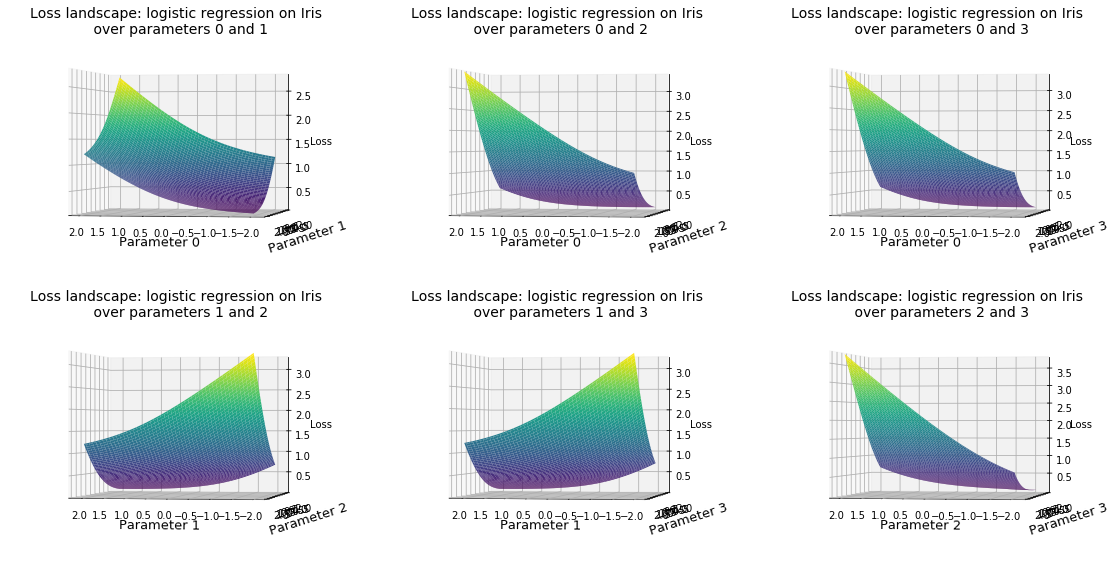

In [9]:
offset = 2
count = 0
fig = plt.figure(figsize=(16, 8))
for i, j in itertools.combinations(range(4), 2):
    # Sweep out values for parameters i and j (non-constant parameters)
    theta_to_change_i = theta[i]
    theta_to_change_i_sweep = np.linspace(start=(theta_to_change_i - offset), 
                                          stop=(theta_to_change_i + offset), num=100)
    theta_to_change_j = theta[j]
    theta_to_change_j_sweep = np.linspace(start=(theta_to_change_j - offset), 
                                          stop=(theta_to_change_j + offset), num=100)
    # Create a meshgrid of non-constant parameters
    theta_i_points, theta_j_points = np.meshgrid(theta_to_change_i_sweep, theta_to_change_j_sweep)
    grid_rows, grid_cols = theta_i_points.shape
    loss = np.zeros((grid_rows, grid_cols))
    for l in range(grid_rows):
        for m in range(grid_cols):
            # Keep all other parameters constant, insert non-constant parameters i, j
            theta_modified = np.copy(theta)
            theta_modified[i] = theta_i_points[l][m]
            theta_modified[j] = theta_j_points[l][m]
            loss[l, m] = lr_model.loss(X, y, theta_modified)[0]   # Evaluate loss for parameter combination
    ax = fig.add_subplot(2, 3, count+1, projection='3d')
    ax.plot_surface(theta_i_points, theta_j_points, loss, cmap='viridis')
    ax.set_title('Loss landscape: logistic regression on Iris \n over parameters {} and {}'.format(i, j), fontsize=14)
    ax.set_xlabel('Parameter {}'.format(i), fontsize=13)
    ax.set_ylabel('Parameter {}'.format(j), fontsize=13)
    ax.set_zlabel('Loss')
    ax.view_init(0, 100)
    count += 1
plt.tight_layout()

Saving theta and loss values

In [10]:
for i, j in itertools.combinations(range(4), 2):  # For each pair of parameters
    theta_to_change_i = theta[i]
    theta_to_change_i_sweep = np.linspace(start=(theta_to_change_i - offset), 
                                          stop=(theta_to_change_i + offset), num=100)
    theta_to_change_j = theta[j]
    theta_to_change_j_sweep = np.linspace(start=(theta_to_change_j - offset), 
                                          stop=(theta_to_change_j + offset), num=100)
    # Create a meshgrid of non-constant parameters
    theta_i_points, theta_j_points = np.meshgrid(theta_to_change_i_sweep, theta_to_change_j_sweep)
    grid_rows, grid_cols = theta_i_points.shape
    loss = np.zeros((grid_rows, grid_cols))
    for l in range(grid_rows):
        for m in range(grid_cols):
            # Keep all other parameters constant, insert non-constant parameters i, j
            theta_modified = np.copy(theta)
            theta_modified[i] = theta_i_points[l][m]
            theta_modified[j] = theta_j_points[l][m]
            loss[l, m] = lr_model.loss(X, y, theta_modified)[0]   # Evaluate loss for parameter combination
    df = pd.DataFrame({
                        'theta_{}'.format(i): theta_i_points.reshape(100**2),
                        'theta_{}'.format(j): theta_j_points.reshape(100**2),
                        'loss': loss.reshape(100**2)
                      }, columns = ['theta_{}'.format(i), 'theta_{}'.format(j), 'loss'])
    df.to_csv('data/no_pca_loss_landscapes/loss_LR_iris_params_{}_{}.csv'.format(i, j), 
              index=False)

#### Train an SVM model

In [11]:
svm_model = SVM()
theta, loss, err = svm_model.gradient_descent(X, y, 0.1, 100)
print(theta.shape)
theta = theta[-1]   # chose best theta
theta

(100, 4)


array([-0.07246395,  0.06805907, -0.09650933, -0.09553447])

#### Visualize loss landscape for SVM model

Visualize loss surface by holding all but one parameter constant at their optimal values. Sweep out values of the non-constant parameter around it's optimal value. Evaluate the loss for each combination of parameter values.

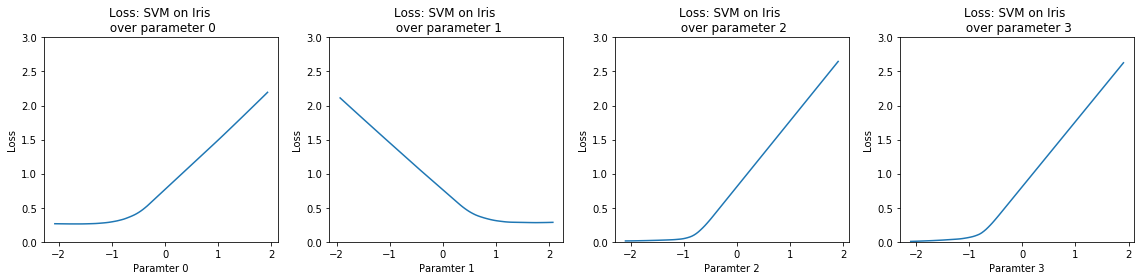

In [12]:
offset = 2   # constant used to sweep out parameter values
plt.figure(figsize=(16, 4))
for i in range(len(theta)):
    theta_to_change = theta[i]   # the parameter value not held constant
    theta_to_change_sweep = np.linspace(start=(theta_to_change - offset), 
                                        stop=(theta_to_change + offset), num=100)
    all_theta_values = np.vstack([theta for i in range(100)])   # stack theta values
    all_theta_values[:,i] = theta_to_change_sweep   # insert in non-constant theta values
    loss = [svm_model.loss(X, y, theta_)[0] for theta_ in all_theta_values]
    error = [svm_model.loss(X, y, theta_)[1] for theta_ in all_theta_values]
    plt.subplot(1, 4, i+1)
    plt.ylim([0,3])
    plt.plot(theta_to_change_sweep, loss)
    plt.title('Loss: SVM on Iris \n over parameter {}'.format(i))
    plt.ylabel('Loss')
    plt.xlabel('Paramter {}'.format(i))
plt.tight_layout()

Visualize loss surface by holding all but two parameters constant at their optimal values. Sweep out values of the non-constant parameters around their optimal values. Evaluate the loss for each combination of parameter values.

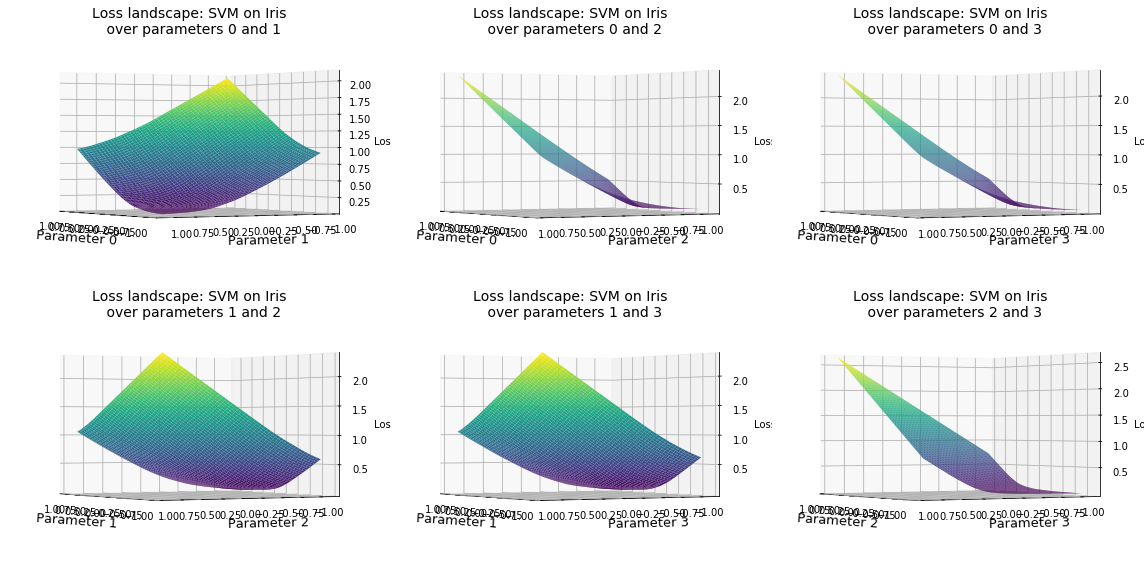

In [13]:
offset = 1
count = 0
fig = plt.figure(figsize=(16, 8))
for i, j in itertools.combinations(range(4), 2):
    # Sweep out values for parameters i and j (non-constant parameters)
    theta_to_change_i = theta[i]
    theta_to_change_i_sweep = np.linspace(start=(theta_to_change_i - offset), 
                                          stop=(theta_to_change_i + offset), num=100)
    theta_to_change_j = theta[j]
    theta_to_change_j_sweep = np.linspace(start=(theta_to_change_j - offset), 
                                          stop=(theta_to_change_j + offset), num=100)
    # Create a meshgrid of non-constant parameters
    theta_i_points, theta_j_points = np.meshgrid(theta_to_change_i_sweep, theta_to_change_j_sweep)
    grid_rows, grid_cols = theta_i_points.shape
    loss = np.zeros((grid_rows, grid_cols))
    for l in range(grid_rows):
        for m in range(grid_cols):
            # Keep all other parameters constant, insert non-constant parameters i, j
            theta_modified = np.copy(theta)
            theta_modified[i] = theta_i_points[l][m]
            theta_modified[j] = theta_j_points[l][m]
            loss[l, m] = svm_model.loss(X, y, theta_modified)[0]   # Evaluate loss for parameter combination
    ax = fig.add_subplot(2, 3, count+1, projection='3d')
    ax.plot_surface(theta_i_points, theta_j_points, loss, cmap='viridis')
    ax.set_title('Loss landscape: SVM on Iris \n over parameters {} and {}'.format(i, j), fontsize=14)
    ax.set_xlabel('Parameter {}'.format(i), fontsize=13)
    ax.set_ylabel('Parameter {}'.format(j), fontsize=13)
    ax.set_zlabel('Loss')
    ax.view_init(0, 150)
    count += 1
plt.tight_layout()

Saving theta and loss values

In [14]:
for i, j in itertools.combinations(range(4), 2):  # For each pair of parameters
    theta_to_change_i = theta[i]
    theta_to_change_i_sweep = np.linspace(start=(theta_to_change_i - offset), 
                                          stop=(theta_to_change_i + offset), num=100)
    theta_to_change_j = theta[j]
    theta_to_change_j_sweep = np.linspace(start=(theta_to_change_j - offset), 
                                          stop=(theta_to_change_j + offset), num=100)
    # Create a meshgrid of non-constant parameters
    theta_i_points, theta_j_points = np.meshgrid(theta_to_change_i_sweep, theta_to_change_j_sweep)
    grid_rows, grid_cols = theta_i_points.shape
    loss = np.zeros((grid_rows, grid_cols))
    for l in range(grid_rows):
        for m in range(grid_cols):
            # Keep all other parameters constant, insert non-constant parameters i, j
            theta_modified = np.copy(theta)
            theta_modified[i] = theta_i_points[l][m]
            theta_modified[j] = theta_j_points[l][m]
            loss[l, m] = svm_model.loss(X, y, theta_modified)[0]   # Evaluate loss for parameter combination
    df = pd.DataFrame({
                        'theta_{}'.format(i): theta_i_points.reshape(100**2),
                        'theta_{}'.format(j): theta_j_points.reshape(100**2),
                        'loss': loss.reshape(100**2)
                      }, columns = ['theta_{}'.format(i), 'theta_{}'.format(j), 'loss'])
    df.to_csv('data/no_pca_loss_landscapes/loss_SVM_iris_params_{}_{}.csv'.format(i, j), 
              index=False)

### Dataset: Breast Cancer

In [15]:
df = pd.read_csv("data/breast-cancer.csv")
df = df.drop(['id', 'Unnamed: 32'], axis=1)
print('Dimensions:', df.shape)
df.head()

Dimensions: (569, 31)


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


#### Train a logistic regression model

In [16]:
X = df.iloc[:,1:31].as_matrix()
# Normalize features: zero mean, unit variance
X = (X - X.mean(axis=0))/X.std(axis=0)
y = ((df['diagnosis'] == 'M') * 2 - 1).as_matrix()   # convert to 1 / -1 labels
lr_model = LogisticRegression()
theta, loss, err = lr_model.gradient_descent(X, y, 0.1, 100)

In [17]:
theta = theta[-1]   # chose best theta
print(theta.shape)
theta

(30,)


array([ 0.02739434,  0.01622885,  0.02776786,  0.02638622,  0.01293119,
        0.0211913 ,  0.02523177,  0.0287292 ,  0.01177896, -0.00181692,
        0.02060893, -0.00059345,  0.01995792,  0.01970376, -0.00296229,
        0.00926405,  0.00786048,  0.01414294, -0.00101336,  0.00130119,
        0.02931013,  0.01812252,  0.0293959 ,  0.02742959,  0.01618999,
        0.0216754 ,  0.02431648,  0.02976021,  0.01603193,  0.01170923])

#### Visualize loss landscape for logistic regression model

Visualize loss surface by holding all but two parameters constant at their optimal values. Sweep out values of the non-constant parameters around their optimal values. Evaluate the loss for each combination of parameter values.

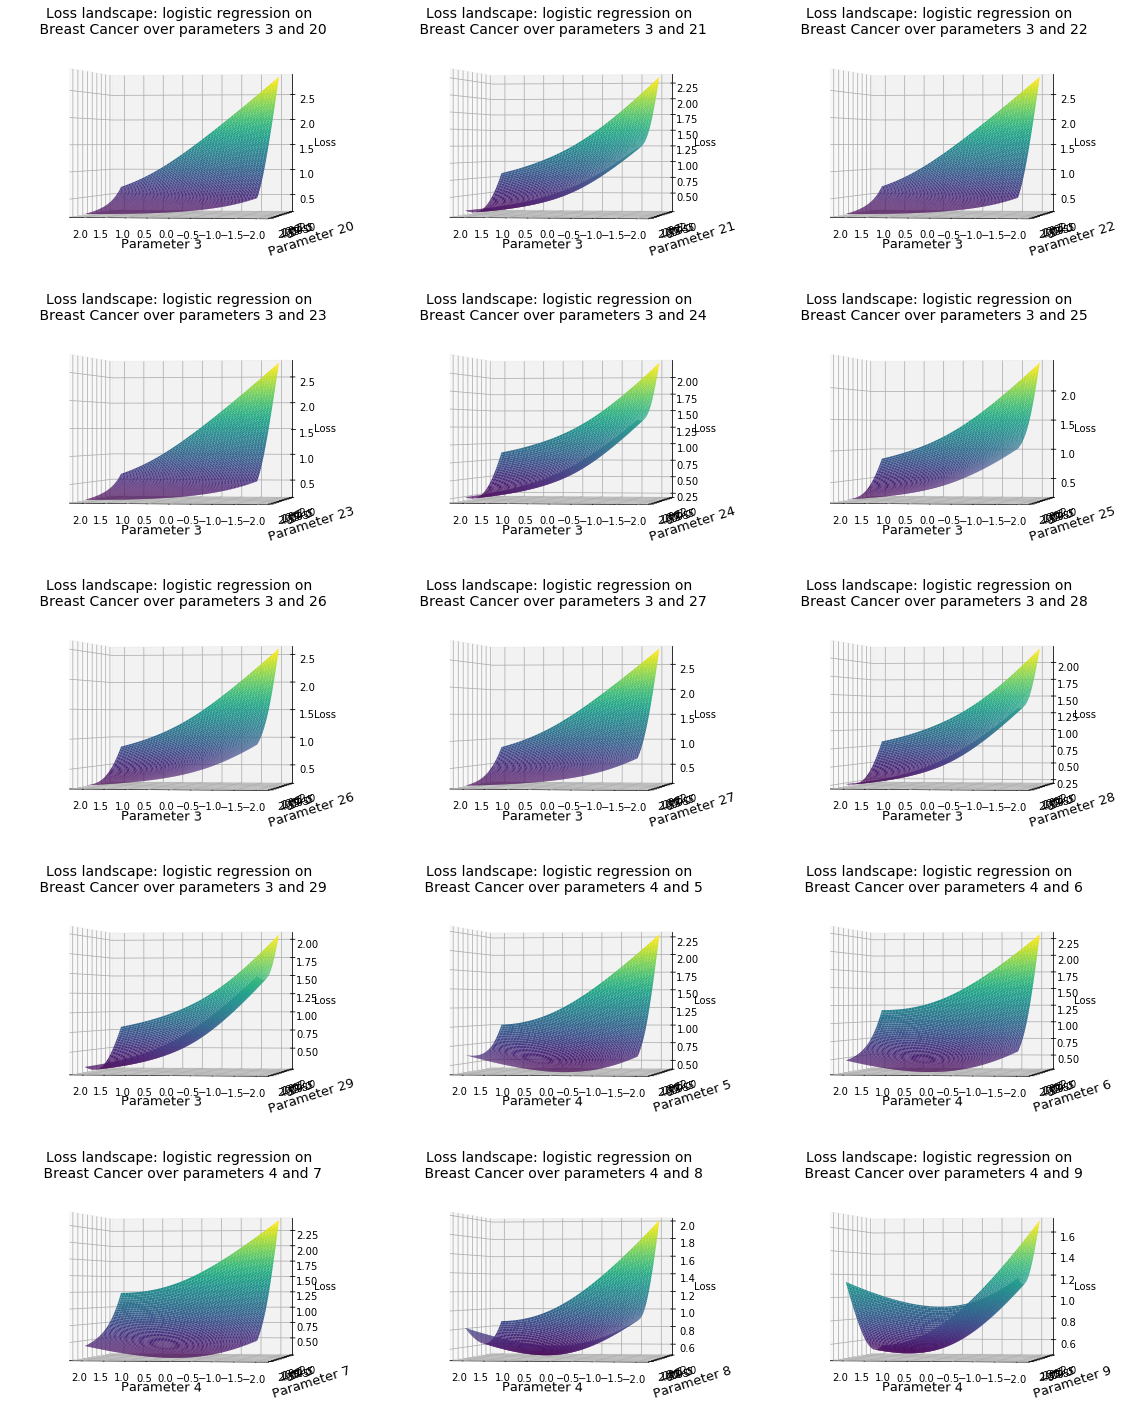

In [18]:
offset = 2
count = 0
fig = plt.figure(figsize=(16, 20))
for i, j in list(itertools.combinations(range(30), 2))[100:115]:
    # Sweep out values for parameters i and j (non-constant parameters)
    theta_to_change_i = theta[i]
    theta_to_change_i_sweep = np.linspace(start=(theta_to_change_i - offset), 
                                          stop=(theta_to_change_i + offset), num=100)
    theta_to_change_j = theta[j]
    theta_to_change_j_sweep = np.linspace(start=(theta_to_change_j - offset), 
                                          stop=(theta_to_change_j + offset), num=100)
    # Create a meshgrid of non-constant parameters
    theta_i_points, theta_j_points = np.meshgrid(theta_to_change_i_sweep, theta_to_change_j_sweep)
    grid_rows, grid_cols = theta_i_points.shape
    loss = np.zeros((grid_rows, grid_cols))
    for l in range(grid_rows):
        for m in range(grid_cols):
            # Keep all other parameters constant, insert non-constant parameters i, j
            theta_modified = np.copy(theta)
            theta_modified[i] = theta_i_points[l][m]
            theta_modified[j] = theta_j_points[l][m]
            loss[l, m] = lr_model.loss(X, y, theta_modified)[0]   # Evaluate loss for parameter combination
    ax = fig.add_subplot(5, 3, count+1, projection='3d')
    ax.plot_surface(theta_i_points, theta_j_points, loss, cmap='viridis')
    ax.set_title('Loss landscape: logistic regression on \n Breast Cancer over parameters {} and {}'.format(i, j), fontsize=14)
    ax.set_xlabel('Parameter {}'.format(i), fontsize=13)
    ax.set_ylabel('Parameter {}'.format(j), fontsize=13)
    ax.set_zlabel('Loss')
    ax.view_init(0, 100)
    count += 1
plt.tight_layout()

#### Train a SVM model

In [19]:
X = df.iloc[:,1:31].as_matrix()
# Normalize features: zero mean, unit variance
X = (X - X.mean(axis=0))/X.std(axis=0)
y = ((df['diagnosis'] == 'M') * 2 - 1).as_matrix()   # convert to 1 / -1 labels
svm_model = SVM()
theta, loss, err = svm_model.gradient_descent(X, y, 0.1, 100)

In [20]:
theta = theta[-1]   # chose best theta
print(theta.shape)
theta

(30,)


array([ 0.05285892,  0.03244896,  0.05341922,  0.04979358,  0.02541813,
        0.04057119,  0.04877577,  0.05560676,  0.02304972, -0.00431893,
        0.03651479, -0.00019123,  0.03496141,  0.03408287, -0.0064343 ,
        0.01835414,  0.0165465 ,  0.02913695, -0.00312195,  0.00290396,
        0.05599922,  0.03734078,  0.05598332,  0.05085704,  0.03299631,
        0.04277726,  0.04852328,  0.05953674,  0.03230319,  0.02323519])

#### Visualize loss landscape for SVM model

Visualize loss surface by holding all but two parameters constant at their optimal values. Sweep out values of the non-constant parameters around their optimal values. Evaluate the loss for each combination of parameter values.

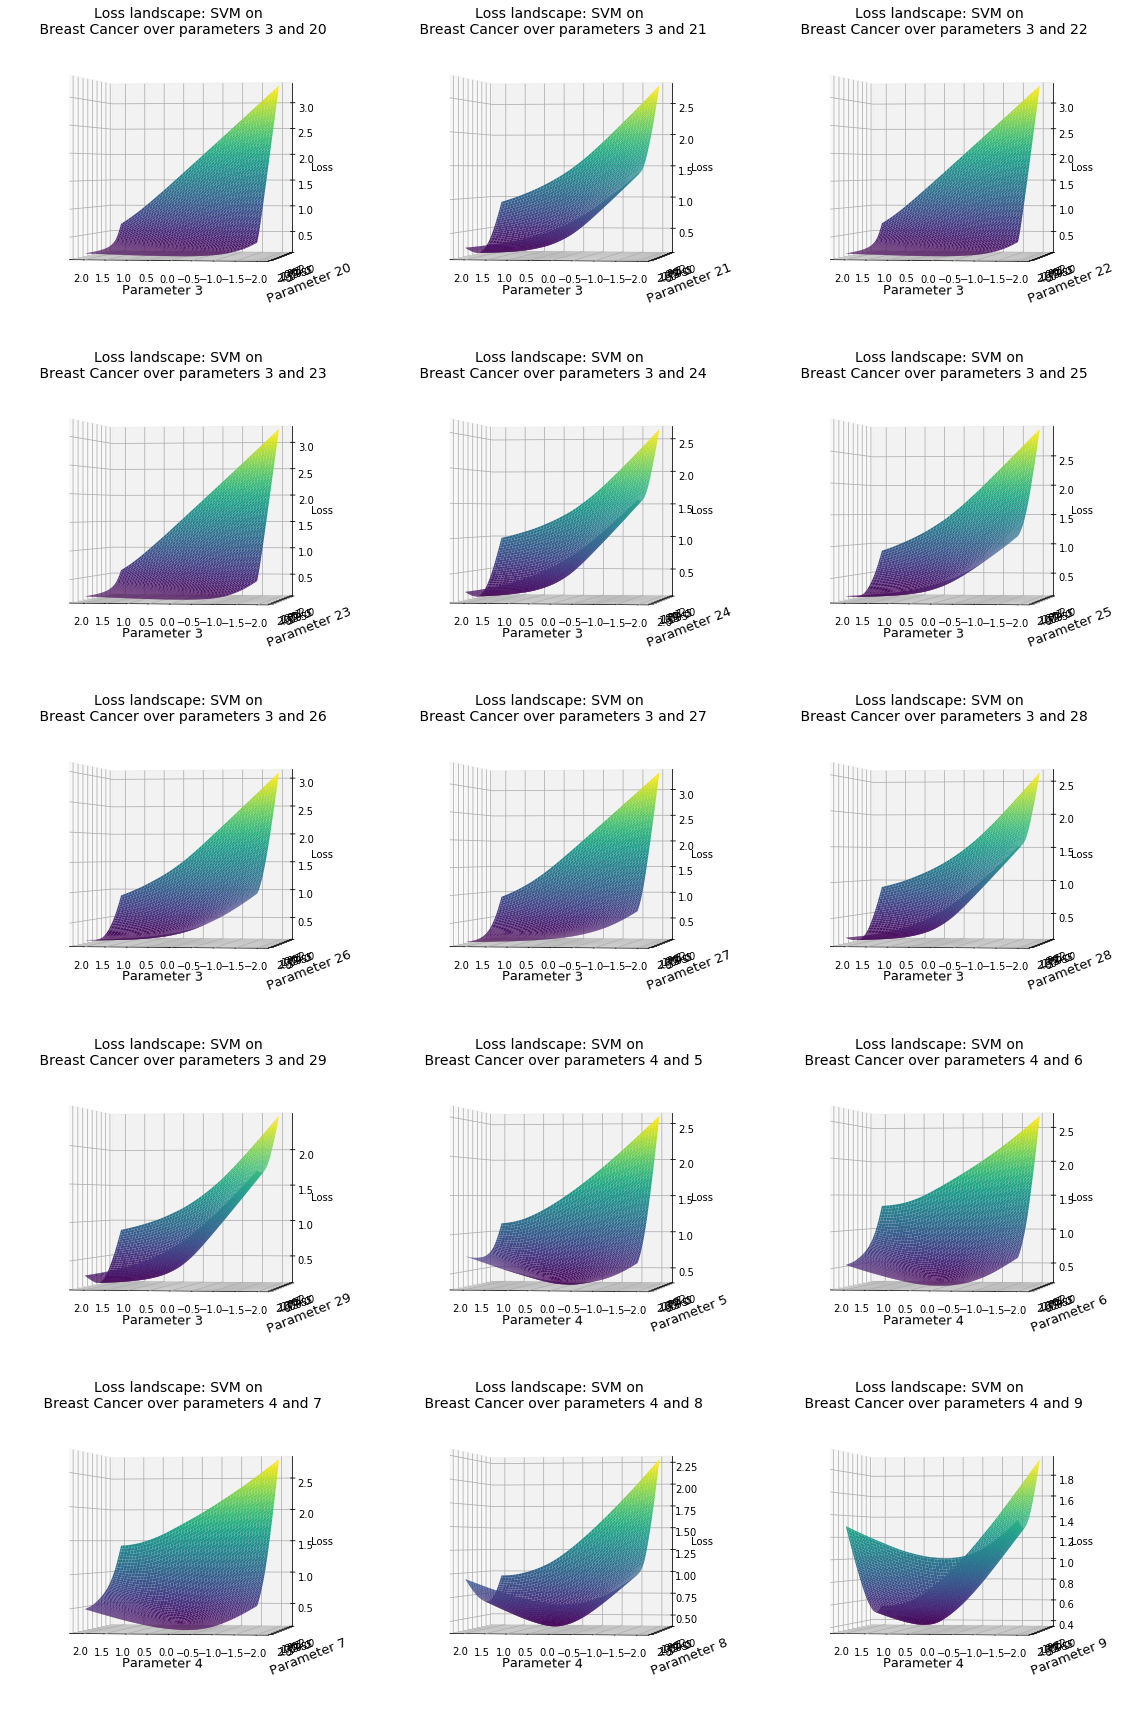

In [21]:
offset = 2
count = 0
fig = plt.figure(figsize=(16, 24))
for i, j in list(itertools.combinations(range(30), 2))[100:115]:
    # Sweep out values for parameters i and j (non-constant parameters)
    theta_to_change_i = theta[i]
    theta_to_change_i_sweep = np.linspace(start=(theta_to_change_i - offset), 
                                          stop=(theta_to_change_i + offset), num=100)
    theta_to_change_j = theta[j]
    theta_to_change_j_sweep = np.linspace(start=(theta_to_change_j - offset), 
                                          stop=(theta_to_change_j + offset), num=100)
    # Create a meshgrid of non-constant parameters
    theta_i_points, theta_j_points = np.meshgrid(theta_to_change_i_sweep, theta_to_change_j_sweep)
    grid_rows, grid_cols = theta_i_points.shape
    loss = np.zeros((grid_rows, grid_cols))
    for l in range(grid_rows):
        for m in range(grid_cols):
            # Keep all other parameters constant, insert non-constant parameters i, j
            theta_modified = np.copy(theta)
            theta_modified[i] = theta_i_points[l][m]
            theta_modified[j] = theta_j_points[l][m]
            loss[l, m] = svm_model.loss(X, y, theta_modified)[0]   # Evaluate loss for parameter combination
    ax = fig.add_subplot(5, 3, count+1, projection='3d')
    ax.plot_surface(theta_i_points, theta_j_points, loss, cmap='viridis')
    ax.set_title('Loss landscape: SVM on \n Breast Cancer over parameters {} and {}'.format(i, j), fontsize=14)
    ax.set_xlabel('Parameter {}'.format(i), fontsize=13)
    ax.set_ylabel('Parameter {}'.format(j), fontsize=13)
    ax.set_zlabel('Loss')
    ax.view_init(0, 100)
    count += 1
plt.tight_layout()